<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/LogisticRegression_bwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [44]:
%pip install torchmetrics --quiet

In [45]:
import torchmetrics
import torchvision

In [46]:
#Load the dataset
penguins = tfds.load('penguins', as_supervised=True, split='train')

In [47]:
X, y = penguins.batch(500).get_single_element()
X, y = X.numpy(), y.numpy()

In [48]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [49]:
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

In [50]:
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

In [51]:
from torch import nn

In [52]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self, input_size, w, b):
    super().__init__()
    self.weight = nn.Parameter(w)
    self.bias = nn.Parameter(b)

  def forward(self, x):
    x = x.reshape(1, -1)
    return torch.softmax(x@self.weight + self.bias, 1)

In [53]:
# We check if CUDA is available. If you do not see it,
# activate a GPU from Runtime >> Change runtime type and 
# restart the notebook.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [54]:
w = torch.randn((4, 3), requires_grad=True)
b = torch.randn((3, ), requires_grad=True)
LG = SimpleLogisticRegression(4, w, b).to(device)

In [55]:
print(LG(Xtrain[0].to(device)))

tensor([[0.1089, 0.8515, 0.0396]], grad_fn=<SoftmaxBackward0>)


In [67]:
def pred(x,w,b):
  ypred=torch.randn((x.shape[0],3))
  for j in range (x.shape[0]):
    xj = x[j].reshape(1, -1)
    ypred[j]=torch.softmax(xj@w+b,1)
  return ypred


In [68]:
ypred=pred(Xtrain,w,b)

In [69]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [99]:
# Average accuracy at initialization is 33% (random guessing).
accuracy(ytrain.to(device),ypred.to(device))

tensor(0.2040)

In [59]:
def cross_entropy(ytrue,ypred):
  """ Cross-entropy loss.
  Inputs:
  - ytrue (n,): vector of indices for the correct class.
  - ypred (n, 3): predictions of the model.
  Returns the average cross-entropy.
  """
  # This is called integer array indexing in NumPy:
  # https://numpy.org/doc/stable/user/basics.indexing.html#integer-array-indexing
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [100]:
print(cross_entropy(ytrain,ypred))

tensor(2.2663, grad_fn=<NegBackward0>)


In [79]:
import time 

In [92]:
def train_bwd_gradient(x,y):

  losses = []
  accuracies = []
  errors=[]

  l_rate=0.2

  w = torch.randn((4, 3), requires_grad=True)
  b = torch.randn((3, ), requires_grad=True)

  ypred=pred(x,w,b)

  loss = cross_entropy(ytrain,ypred)

  t=0
  t0=time.time()
  print('Time', t, 'loss', loss)

  while (loss>0.3): 

    loss.backward()

    with torch.no_grad():
      
      # Apply gradients 
      w -= 0.01*w.grad
      b -= 0.01*b.grad

      # Gradients are accumulated: we need to zero them out before the next iteration.
      w.grad.zero_()
      b.grad.zero_()
    
    ypred=pred(x,w,b)

    loss = cross_entropy(ytrain,ypred)

    LG = SimpleLogisticRegression(4, w, b)
    ypredT=torch.randn(Xtest.size(0),3)
    error=0
    for i in range (Xtest.size(0)):
      ypredT[i]=LG(Xtest[i])
      if (LG(Xtest[i]).argmax(1)- ytest[i])!=0:
        error = error+ 1

    errors.append(error)
    accuracies.append(accuracy(ytest,ypredT).item())
    losses.append(cross_entropy(ytest,ypredT).detach().item())

    t1=time.time()
    t+=t1-t0
    t0=t1
    print('Time', t, 'loss', loss)
  
  return w,b,errors,losses,accuracies


In [93]:
w, b,errors,losses,accuracies = train_bwd_gradient(Xtrain, ytrain)

Se han truncado las últimas 5000 líneas del flujo de salida.
Time 136.38462018966675 loss tensor(0.4979, grad_fn=<NegBackward0>)
Time 136.43344712257385 loss tensor(0.4978, grad_fn=<NegBackward0>)
Time 136.47366285324097 loss tensor(0.4977, grad_fn=<NegBackward0>)
Time 136.5220251083374 loss tensor(0.4977, grad_fn=<NegBackward0>)
Time 136.56283450126648 loss tensor(0.4976, grad_fn=<NegBackward0>)
Time 136.60857582092285 loss tensor(0.4975, grad_fn=<NegBackward0>)
Time 136.6493067741394 loss tensor(0.4974, grad_fn=<NegBackward0>)
Time 136.68961715698242 loss tensor(0.4974, grad_fn=<NegBackward0>)
Time 136.73976969718933 loss tensor(0.4973, grad_fn=<NegBackward0>)
Time 136.79259538650513 loss tensor(0.4972, grad_fn=<NegBackward0>)
Time 136.83340787887573 loss tensor(0.4972, grad_fn=<NegBackward0>)
Time 136.874018907547 loss tensor(0.4971, grad_fn=<NegBackward0>)
Time 136.93843722343445 loss tensor(0.4970, grad_fn=<NegBackward0>)
Time 136.989595413208 loss tensor(0.4969, grad_fn=<NegBackw

In [94]:
import matplotlib.pyplot as plt

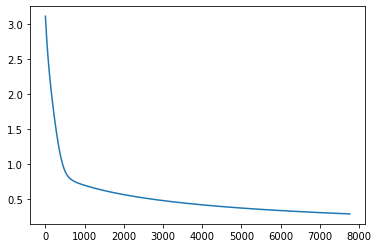

In [95]:
plt.plot(losses)

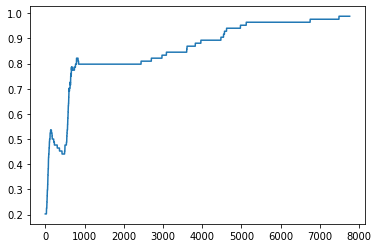

In [96]:
plt.plot(accuracies)

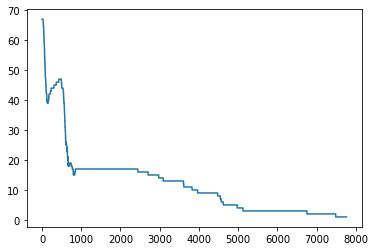

In [97]:
plt.plot(errors)